In [40]:
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32, remove_noise_satellite


def get_processed_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_raw, dataset_raw)

In [41]:
# haal dataset op waar je molens kan zien
dataset_raw = rasterio.open("./data/crs.tiff")
img_raw = dataset_raw.read(1)
block_size = 30

In [42]:
from cv2 import cv2 as cv

# haal dataset op waar we kunnen afleiden of we land of water zien
dataset_land = rasterio.open(
    "./data/E000N60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif")
img_land = dataset_land.read(1)

# we zetten hier alles buiten land op 0
img_land[img_land != 200] = 0  # 200 is ocean index
img_land[img_land == 200] = 1

# dilate om kustlijnen uit resultaat te laten
kernel = np.ones((5, 5), np.uint8)
img_land = cv.erode(img_land, kernel, iterations=5)

In [43]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [44]:
import imageio

X = []
Y = []

valid = ["windmills", "boats", "ocean", "beach"]
target = ["windmills", "boats"]

for path in examples:

    category = path.split("/")[2]
    if category not in valid:
        continue

    src = imageio.imread(path)
    src = np.expand_dims(remove_noise_satellite(src) / 255.0, -1)

    # import images oriented 4 ways
    for i in range(4):
        X.append(np.rot90(src.copy(), i))
        if category in target:
            Y.append(1)
        else:
            Y.append(0)

In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [46]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=100)

Epoch 1/100
107/107 [==============================] - 1s 5ms/step - loss: 0.3841 - accuracy: 0.8501 - val_loss: 0.3731 - val_accuracy: 0.8558
Epoch 2/100
107/107 [==============================] - 0s 3ms/step - loss: 0.3264 - accuracy: 0.8756 - val_loss: 0.3406 - val_accuracy: 0.8687
Epoch 3/100
107/107 [==============================] - 0s 4ms/step - loss: 0.3176 - accuracy: 0.8750 - val_loss: 0.3291 - val_accuracy: 0.8710
Epoch 4/100
107/107 [==============================] - 0s 4ms/step - loss: 0.3134 - accuracy: 0.8768 - val_loss: 0.3321 - val_accuracy: 0.8664
Epoch 5/100
107/107 [==============================] - 0s 4ms/step - loss: 0.3174 - accuracy: 0.8747 - val_loss: 0.3322 - val_accuracy: 0.8664
Epoch 6/100
107/107 [==============================] - 0s 4ms/step - loss: 0.3082 - accuracy: 0.8762 - val_loss: 0.3318 - val_accuracy: 0.8664
Epoch 7/100
107/107 [==============================] - 0s 3ms/step - loss: 0.3040 - accuracy: 0.8800 - val_loss: 0.3515 - val_accuracy: 0.8581

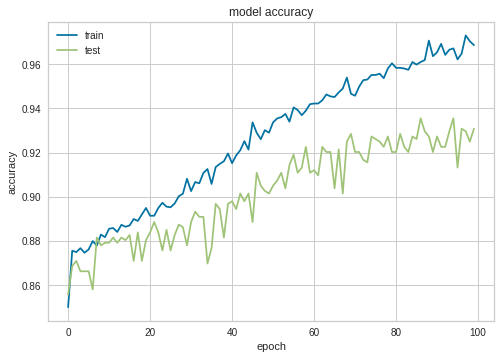

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

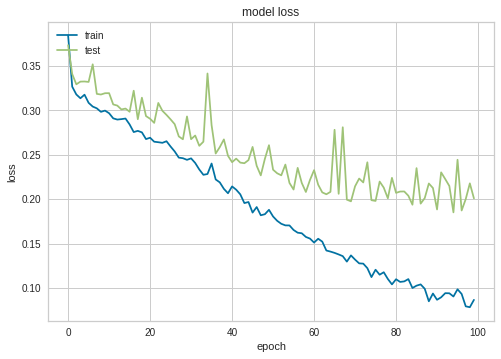

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
model.evaluate(X_test, Y_test, verbose=2)

34/34 - 0s - loss: 0.2011 - accuracy: 0.9287 - 90ms/epoch - 3ms/step


[0.20109346508979797, 0.9287054538726807]

<AxesSubplot:>

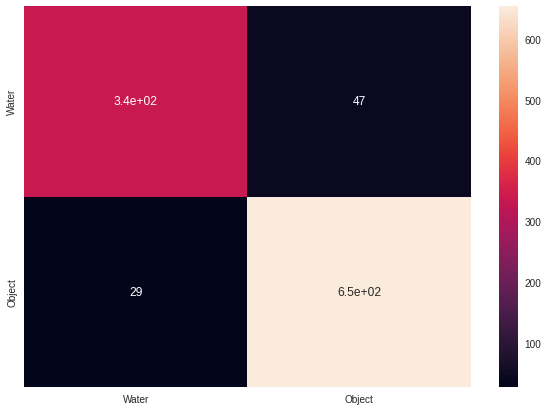

In [51]:
# confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
cm = confusion_matrix([np.argmax(a) for a in Y_test], [np.argmax(a) for a in Y_pred])

df_cm = pd.DataFrame(cm, index=["Water", "Object"], columns=["Water", "Object"])
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True)

In [52]:
def detect_windmills():
    needles = []
    step_size = 15

    [h, w] = dataset_raw.shape
    for xx in range(block_size // 2, w - block_size // 2, step_size):
        for yy in range(block_size // 2, h - block_size // 2, step_size):
            cc = dataset_raw.transform * (yy, xx)
            lx, ly = dataset_land.index(cc[0], cc[1])
            if img_land[lx, ly] != 1:
                continue
            needles.append({'lon': cc[0], 'lat': cc[1]})

    test_images = np.stack([get_processed_image(coord) for coord in needles])
    results = model.predict(test_images)
    coords = []
    for i, result in enumerate(results):
        if i % 1000:
            print(f"{i}/{len(results)}")
        if result[1] > result[0]:
            coords.append(needles[i])
    return coords


def plot_windmills(left_top_coord, size=(1200, 800), intensity=1):
    (img_h, img_w) = size
    left_top_x, left_top_y = dataset_raw.index(left_top_coord[0], left_top_coord[1])
    needles = []
    step_size = 15

    x_count = ((img_h - block_size) // step_size)
    for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
        for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
            cc = dataset_raw.transform * (yy, xx)
            lx, ly = dataset_land.index(cc[0], cc[1])
            if img_land[lx, ly] != 1:
                continue
            needles.append({'lon': cc[0], 'lat': cc[1]})

    test_images = np.stack([get_processed_image(coord) for coord in needles])
    results = model.predict(test_images)

    from matplotlib import pyplot as plt

    search_space = np.copy(img_raw[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
    search_space = search_space ** (1 / 4)
    highlight = np.max(search_space) * 0.75 * intensity

    found = 0
    previous_i = 0
    coords = []
    found_i = []
    for i, result in enumerate(results):
        if result[1] > result[0]:
            if i - previous_i <= 2:
                continue
            if i - x_count in found_i or (i - (x_count * 2)) in found_i or (i + 1 - x_count) in found_i or (
                    i - 1 - x_count) in found_i:
                continue
            found += 1
            previous_i = i
            found_i.append(i)
            coord = needles[i]
            xx, yy = dataset_raw.index(coord['lon'], coord['lat'])
            xx -= left_top_x
            yy -= left_top_y

            search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
            search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
            search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
            coords.append(coord)

    print("found {} windmills".format(found))

    plt.rcParams['figure.figsize'] = [20, 10]
    plt.imshow(search_space)

    return coords

found 54 windmills


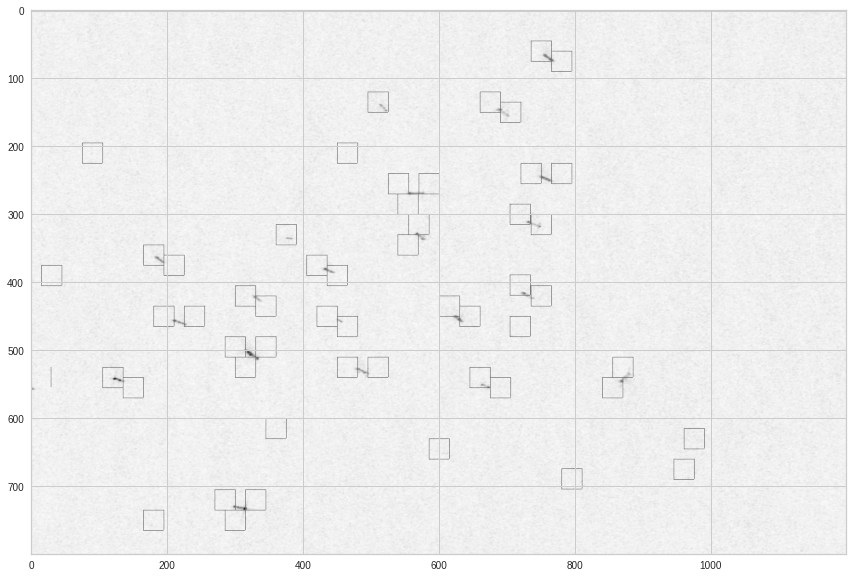

In [54]:
# vb boten
_ = plot_windmills((2.56834, 51.48205))

found 128 windmills


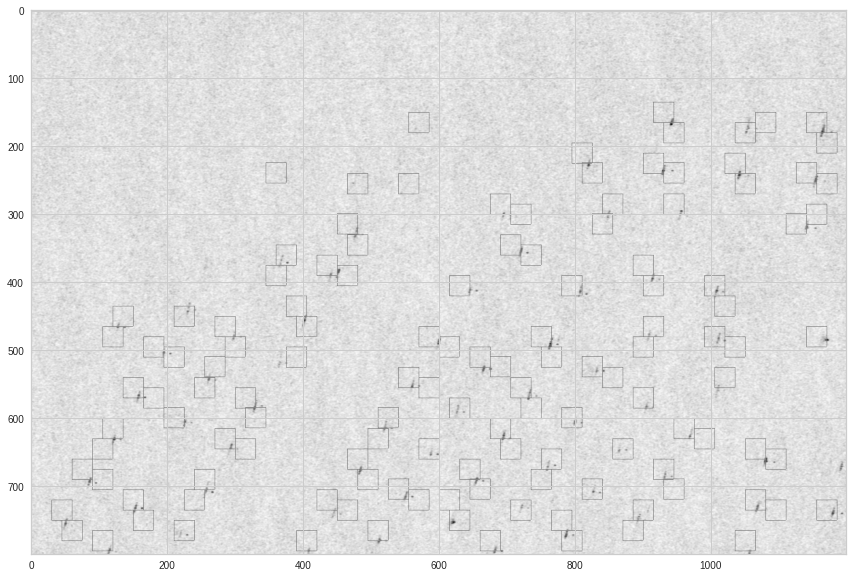

In [55]:
# vb molens
_ = plot_windmills((1.85730, 52.01960))

found 0 windmills


[]

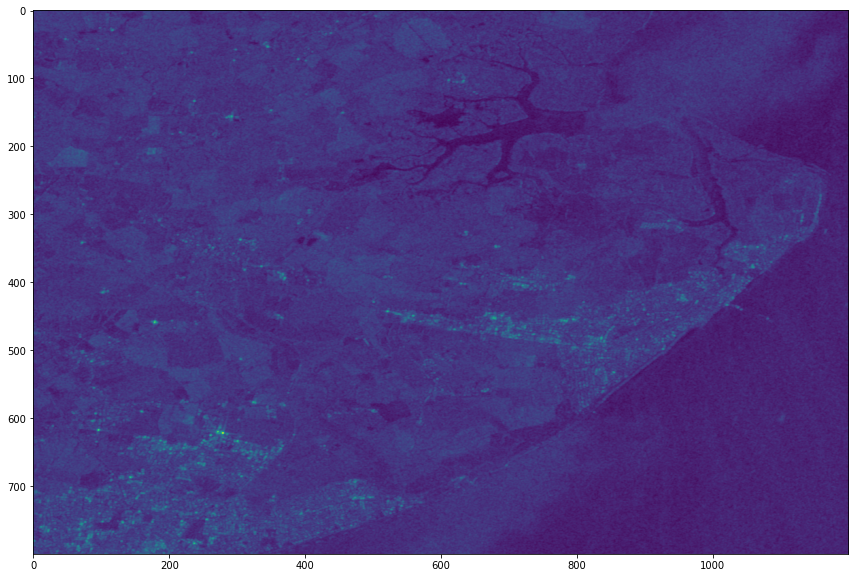

In [32]:
# vb kust
_ = plot_windmills((1.12835, 51.90720))

/tmp/ipykernel_16206/3793571605.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = algo.labels_.astype(np.int)


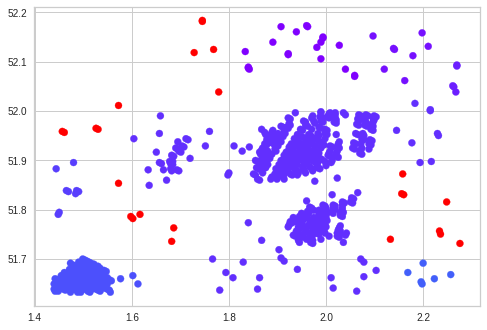

            X          Y  cluster
0    1.744898  52.183574       -1
1    1.744898  52.181470       -1
2    1.959468  52.173056        0
3    1.906877  52.170952        0
4    1.961572  52.170952        0
..        ...        ...      ...
644  1.473530  51.632423        5
645  1.488255  51.632423        5
646  1.494566  51.632423        5
647  1.513499  51.632423        5
648  1.555571  51.632423        5

[649 rows x 3 columns]


In [37]:
from sklearn import cluster
import matplotlib.cm as cm

colors = np.array(['r', 'g', 'b', 'y', 'c', 't'])
colors = cm.rainbow(np.linspace(0, 1, 50))


def apply(X, algo):
    algo.fit(X)
    labels = algo.labels_.astype(np.int)
    plt.scatter(X[:, 0], X[:, 1], color=colors[labels])
    plt.show()
    return labels


df = pd.DataFrame(coords)
X = df.to_numpy()

#labels = apply(X, cluster.KMeans(n_clusters=4))

labels = apply(X, cluster.DBSCAN(eps=.06))
#apply(X, cluster.SpectralClustering(n_clusters=2, affinity="nearest_neighbors"))

cluster_map = pd.DataFrame()
cluster_map['X'] = X[:, 0]
cluster_map['Y'] = X[:, 1]
cluster_map['cluster'] = labels

print(cluster_map)

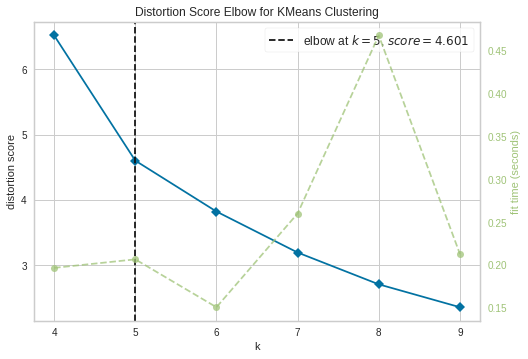

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7fea921acc10>
Traceback (most recent call last):
  File "/home/rudolf/Projects/cs-ml-windmill/venv/lib/python3.9/site-packages/threadpoolctl.py", line 548, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/rudolf/Projects/cs-ml-windmill/venv/lib/python3.9/site-packages/threadpoolctl.py", line 669, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/rudolf/Projects/cs-ml-windmill/venv/lib/python3.9/site-packages/threadpoolctl.py", line 786, in __init__
    super().__init__(**kwargs)
  File "/home/rudolf/Projects/cs-ml-windmill/venv/lib/python3.9/site-packages/threadpoolctl.py", line 754, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.9/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._

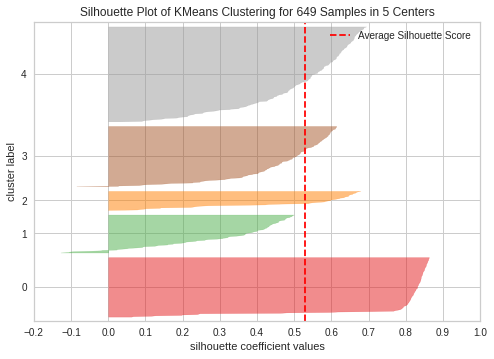

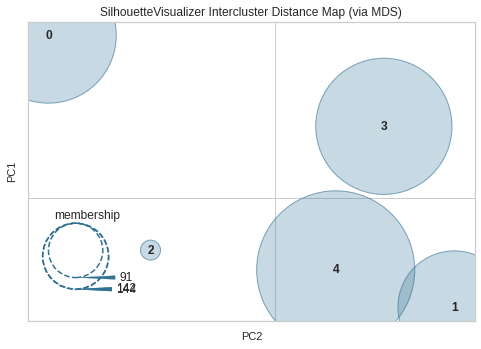

649


In [35]:


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=8, random_state=42)
# X, y = make_blobs(n_samples=1000, centers=5, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 10))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

model = SilhouetteVisualizer(KMeans(5))
model.fit(X)
model.show()

from yellowbrick.cluster import InterclusterDistance

visualizer = InterclusterDistance(model)
visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

print(len(X))

In [36]:
from shapely.geometry import LineString
import geopandas as gpd


def bounding_box(x_coordinates, y_coordinates):
    # x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]


list_lon = []
list_lat = []
list_geom = []

column_values = cluster_map["cluster"].values
clusters = np.unique(column_values)
bboxs = []
for cluster in clusters:
    if (cluster_map[cluster_map.cluster == cluster].shape[0] <= 20):
        continue
    bboxs.append(bounding_box(cluster_map[cluster_map.cluster == cluster]['X'],
                              cluster_map[cluster_map.cluster == cluster]['Y']))

l_lats = []
l_lons = []
boxes = []
for bbox in bboxs:
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[1][0])
    l_lats.append(bbox[0][0])
    l_lats.append(bbox[0][0])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[0][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[1][1])
    l_lons.append(bbox[0][1])

    bb = gpd.points_from_xy(l_lats, l_lons, crs="EPSG:4326")

    boxes.append(LineString(bb))
    l_lats = []
    l_lons = []

df_result = gpd.GeoDataFrame({
    'geometry': boxes
})

df_result['geometry']
from shapely.ops import unary_union

cu = unary_union(df_result['geometry']);
df2_result = gpd.GeoDataFrame({
    'geometry': cu
})

df2_result.crs = 'epsg:4326'
df2_result.to_file("result.shp")